In [1]:
# import dependencies
import psycopg2
import pandas as pd
import numpy as np
import matplotlib as plt
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from config import rds_password

In [2]:
# connect to RDS server to pull bank data
ENDPOINT="database-1.czh7cscocv0o.us-east-2.rds.amazonaws.com"
PORT="5432"
USER="postgres"
REGION="us-east-2c"
DBNAME="postgres"


try:
    conn = psycopg2.connect(host=ENDPOINT, port=PORT, database=DBNAME, user=USER, password=rds_password, sslrootcert="SSLCERTIFICATE")
    cur = conn.cursor()
    cur.execute("SELECT * FROM bank_data")
    query_results = cur.fetchall()
    columns = ['index','age','job','marital','education','credit_default','balance','housing_loan','personal_loan','contact','duration_sec','campaign','pdays','previous','poutcome','subscription','date','weekday']
    bank_df= pd.DataFrame(query_results, columns=columns)
except Exception as e:
    print("Database connection failed due to {}".format(e))

In [4]:
# make dataframe from csv
# bank_df = pd.read_csv("bank-full_2.csv")
# bank_df.head()

,Unnamed: 0,index,age,job,marital,education,credit_default,balance,housing_loan,personal_loan,contact,duration_sec,campaign,pdays,previous,poutcome,subscription,date,weekday
0,0,0,58,management,married,tertiary,no,2143,yes,no,unknown,261,1,-1,0,unknown,no,2008-05-05,Monday
1,1,1,44,technician,single,secondary,no,29,yes,no,unknown,151,1,-1,0,unknown,no,2008-05-05,Monday
2,2,2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,76,1,-1,0,unknown,no,2008-05-05,Monday
3,3,3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,92,1,-1,0,unknown,no,2008-05-05,Monday
4,4,4,33,unknown,single,unknown,no,1,no,no,unknown,198,1,-1,0,unknown,no,2008-05-05,Monday


In [3]:
bank_df

,index,age,job,marital,education,credit_default,balance,housing_loan,personal_loan,contact,duration_sec,campaign,pdays,previous,poutcome,subscription,date,weekday
0,0,58,management,married,tertiary,no,2143,yes,no,unknown,261,1,-1,0,unknown,no,2008-05-05,Monday
1,1,44,technician,single,secondary,no,29,yes,no,unknown,151,1,-1,0,unknown,no,2008-05-05,Monday
2,2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,76,1,-1,0,unknown,no,2008-05-05,Monday
3,3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,92,1,-1,0,unknown,no,2008-05-05,Monday
4,4,33,unknown,single,unknown,no,1,no,no,unknown,198,1,-1,0,unknown,no,2008-05-05,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,45206,51,technician,married,tertiary,no,825,no,no,cellular,977,3,-1,0,unknown,yes,2010-11-17,Wednesday
45207,45207,71,retired,divorced,primary,no,1729,no,no,cellular,456,2,-1,0,unknown,yes,2010-11-17,Wednesday
45208,45208,72,retired,married,secondary,no,5715,no,no,cellular,1127,5,184,3,success,yes,2010-11-17,Wednesday
45209,45209,57,blue-collar,married,secondary,no,668,no,no,telephone,508,4,-1,0,unknown,no,2010-11-17,Wednesday


In [4]:
# check if there are null values and drop if neccessary
bank_df.isnull().values.any()

False

In [5]:
# check if there are duplicate entries in the data
print(f"Duplicate entries: {bank_df.duplicated().sum()}")

Duplicate entries: 0


In [6]:
#drop the index row
bank_df.drop('index',axis=1, inplace=True)

In [7]:
# create list of all the columns that only have 2 potential answers
bank_list_binary = ['credit_default','housing_loan','personal_loan','subscription']

In [8]:
# changing data type of binary choices from object to bool
for x in bank_list_binary:
    bank_df[x]=bank_df[x]=="yes"

In [9]:
# change date to datetime format
bank_df['date']=pd.to_datetime(bank_df['date'])

# create data
dates = bank_df['date']

# calculate unix datetime
bank_df['date']=(dates - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

In [10]:
# create a list of all the columns that contain objects and category
bank_list=[]
bank_list=list(bank_df.select_dtypes(include=['object','category']).columns)

In [11]:
# Create the OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit the encoder and produce encoded DataFrame
encode_df = pd.DataFrame(enc.fit_transform(bank_df[bank_list]))

# Rename encoded columns
encode_df.columns = enc.get_feature_names(bank_list)
encode_df.head()

c:\Users\rab_b\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,poutcome_other,poutcome_success,poutcome_unknown,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Merge the two DataFrames together and drop the columns
bank_df=bank_df.merge(encode_df,left_index=True,right_index=True).drop(bank_list,1)

C:\Users\rab_b\AppData\Local\Temp\ipykernel_7660\765185460.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  bank_df=bank_df.merge(encode_df,left_index=True,right_index=True).drop(bank_list,1)


In [13]:
bank_df

,age,credit_default,balance,housing_loan,personal_loan,duration_sec,campaign,pdays,previous,subscription,...,poutcome_other,poutcome_success,poutcome_unknown,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,58,False,2143,True,False,261,1,-1,0,False,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,44,False,29,True,False,151,1,-1,0,False,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,33,False,2,True,True,76,1,-1,0,False,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,47,False,1506,True,False,92,1,-1,0,False,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,33,False,1,False,False,198,1,-1,0,False,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,False,825,False,False,977,3,-1,0,True,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
45207,71,False,1729,False,False,456,2,-1,0,True,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
45208,72,False,5715,False,False,1127,5,184,3,True,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
45209,57,False,668,False,False,508,4,-1,0,False,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [16]:
# bank_df.drop('Unnamed: 0',axis=1, inplace=True)

In [14]:
# set up data x and y
y = bank_df.subscription
X = bank_df.drop(columns="subscription")

In [15]:
# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [16]:
# Create a random forest classifier.

for x in np.arange(5,101,5):
    rf_model = RandomForestClassifier(n_estimators=x, random_state=1)

    # Fitting the model
    rf_model = rf_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred_test = rf_model.predict(X_test)
    y_pred_train = rf_model.predict(X_train)
    prec=precision_score(y_test, y_pred_test)
    print(f" estimator: {x}, precision {prec}") 


 estimator: 5, precision 0.5757575757575758
 estimator: 10, precision 0.6272040302267002
 estimator: 15, precision 0.6297872340425532
 estimator: 20, precision 0.6324062877871826
 estimator: 25, precision 0.6306695464362851
 estimator: 30, precision 0.6469194312796208
 estimator: 35, precision 0.6493362831858407
 estimator: 40, precision 0.6576151121605667
 estimator: 45, precision 0.6472564389697648
 estimator: 50, precision 0.6585081585081585
 estimator: 55, precision 0.6572398190045249
 estimator: 60, precision 0.6651053864168618
 estimator: 65, precision 0.6551339285714286
 estimator: 70, precision 0.6581096849474912
 estimator: 75, precision 0.6523702031602708
 estimator: 80, precision 0.649365628604383
 estimator: 85, precision 0.6464646464646465
 estimator: 90, precision 0.6481271282633371
 estimator: 95, precision 0.6471238938053098
 estimator: 100, precision 0.6537142857142857


In [17]:
# Create a random forest classifier.

for x in np.arange(50,71,2):
    rf_model = RandomForestClassifier(n_estimators=x, random_state=1)

    # Fitting the model
    rf_model = rf_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred_test = rf_model.predict(X_test)
    y_pred_train = rf_model.predict(X_train)
    prec=precision_score(y_test, y_pred_test)
    print(f" estimator: {x}, precision {prec}") 

 estimator: 50, precision 0.6585081585081585
 estimator: 52, precision 0.6558139534883721
 estimator: 54, precision 0.6573099415204678
 estimator: 56, precision 0.6593023255813953
 estimator: 58, precision 0.6628041714947857
 estimator: 60, precision 0.6651053864168618
 estimator: 62, precision 0.6643437862950058
 estimator: 64, precision 0.6639629200463499
 estimator: 66, precision 0.6624129930394431
 estimator: 68, precision 0.6585365853658537
 estimator: 70, precision 0.6581096849474912


In [18]:
rf_model = RandomForestClassifier(n_estimators=60, random_state=1)

# Fitting the model
rf_model = rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred_test = rf_model.predict(X_test)
y_pred_train = rf_model.predict(X_train)

conf_df= pd.DataFrame(confusion_matrix(y_test, y_pred_test), columns =['Pred_Neg','Pred_Pos'] , index=['Actual_Neg', 'Actual_Pos'] )
print(classification_report(y_test, y_pred_test))

print('Training set metrics:')
print('Accuracy:', accuracy_score(y_train, y_pred_train))
print('Precision:', precision_score(y_train, y_pred_train))
print('Recall:', recall_score(y_train, y_pred_train))

print('Test set metrics:')
print('Accuracy:', accuracy_score(y_test, y_pred_test)) 
print('Precision:', precision_score(y_test, y_pred_test)) 
print('Recall:', recall_score(y_test, y_pred_test)) 
conf_df

              precision    recall  f1-score   support

       False       0.93      0.97      0.95     10002
        True       0.67      0.44      0.53      1301

    accuracy                           0.91     11303
   macro avg       0.80      0.70      0.74     11303
weighted avg       0.90      0.91      0.90     11303

Training set metrics:
Accuracy: 0.9998820337383508
Precision: 1.0
Recall: 0.9989969909729187
Test set metrics:
Accuracy: 0.9098469432893922
Precision: 0.6651053864168618
Recall: 0.43658724058416604


,Pred_Neg,Pred_Pos
Actual_Neg,9716,286
Actual_Pos,733,568


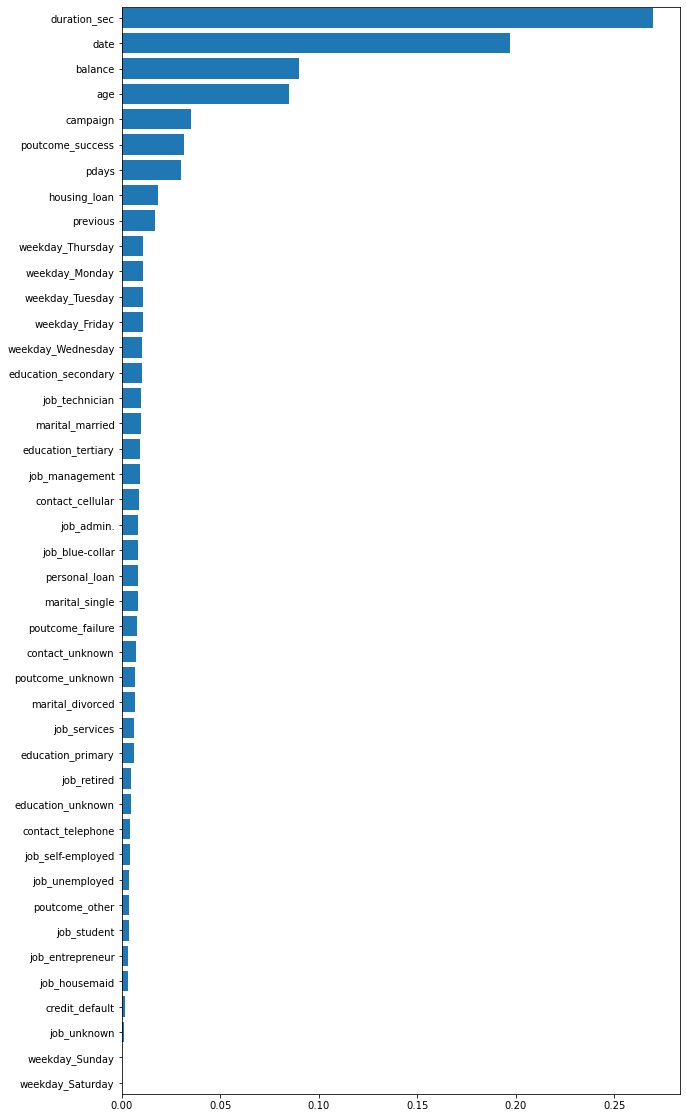

In [19]:
features = rf_model.feature_importances_
features = sorted(zip(X.columns, rf_model.feature_importances_), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(10,20)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()

In [20]:
conf_df.to_csv('confusion_matrix.csv')